In [7]:
from typing import Annotated, Sequence, TypedDict
# from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b 

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]

model = ChatGroq(model='llama3-8b-8192')


def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
    

graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    # should_continue,
    # {
    #     "continue": "tools",
    #     "end": END,
    # },
    tools_condition
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()



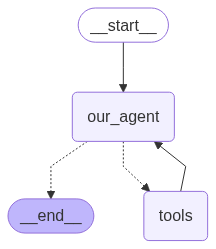

In [8]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 2")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 2
================================== Ai Message ==================================

Let's follow your instructions:

1. Add 40 + 12:
40 + 12 = 52

2. Multiply the result by 2:
52 × 2 = 104

So, the final answer is 104!


In [5]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 2 and tell me a joke")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 2 and tell me a joke
================================== Ai Message ==================================

Let's do the math first!

40 + 12 = 52

Then, let's multiply the result by 2:

52 × 2 = 104

And now, here's a joke:

Why don't scientists trust atoms?

Because they make up everything!

I hope that made you smile!
